In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import confusion_matrix, roc_curve, auc  
from sklearn.cluster import KMeans  
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Set up script path for importing functions
script_path = os.path.abspath(os.path.join(os.getcwd(), "..", "scripts"))
sys.path.append(script_path)

# Import functions from the Python script
from capstone_group_1 import load_and_clean_data, train_regression_model, train_classification_model, train_clustering_model
from capstone_group_1 import train_decision_tree_classifier

# Load Data
file_path = "../dataset/sampled_online_retail_sales_dataset.csv"
df = load_and_clean_data(file_path)

# our sampled dataset url link:- https://www.kaggle.com/datasets/deep020/sampled-data-set
# url of dataset from we taken nearly 40000 random transaction into above dataset :- https://www.kaggle.com/datasets/arnavsmayan/online-retail-sales-dataset/data

# Data Exploration
print(df.head())
print(df.info())
df.isnull().sum()

# Ensure no negative values in price and quantity
df = df[df['quantity'] > 0]
df = df[df['price'] > 0]

# Create 'total_amount' column
df['total_amount'] = df['quantity'] * df['price'] * (1 - df['discount'])

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['OrderMonth'] = df['timestamp'].dt.to_period('M').astype(str)

    transaction_id           timestamp  customer_id  product_id  \
0         987232.0 2024-11-16 13:51:00       2643.0       850.0   
2         567131.0 2024-01-29 20:10:00       1792.0       429.0   
5         135050.0 2023-04-04 18:49:00       3308.0       315.0   
18        376762.0 2023-09-19 15:21:00       4865.0       169.0   
35        543083.0 2024-01-13 03:22:00       4616.0       538.0   

     product_category  quantity   price  discount payment_method  \
0            Clothing       7.0  254.78      0.44         PayPal   
2      Home & Kitchen       7.0  100.96      0.46    Credit Card   
5               Books       6.0   51.49      0.15         PayPal   
18  Sports & Outdoors       7.0  271.47      0.41    Credit Card   
35              Books       7.0  467.28      0.33    Credit Card   

    customer_age customer_gender customer_location  total_amount  
0           47.0          Female     South America        998.74  
2           46.0          Female     North America    

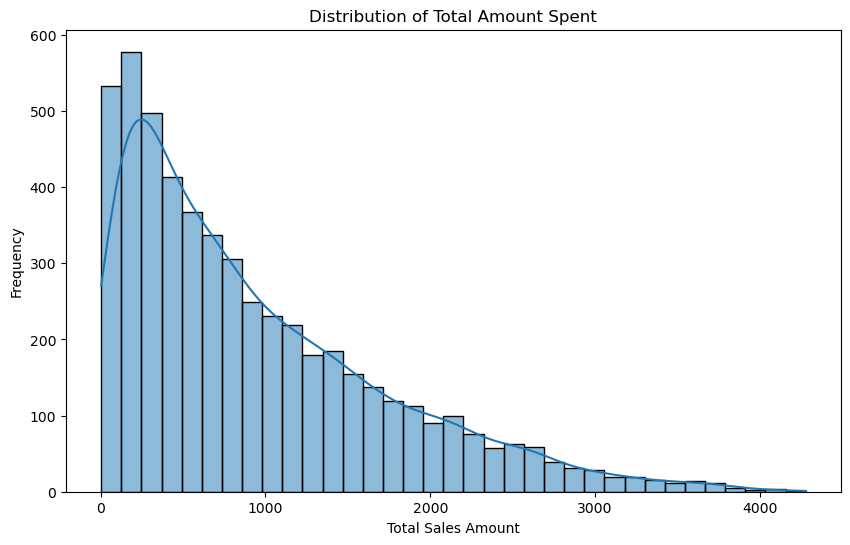

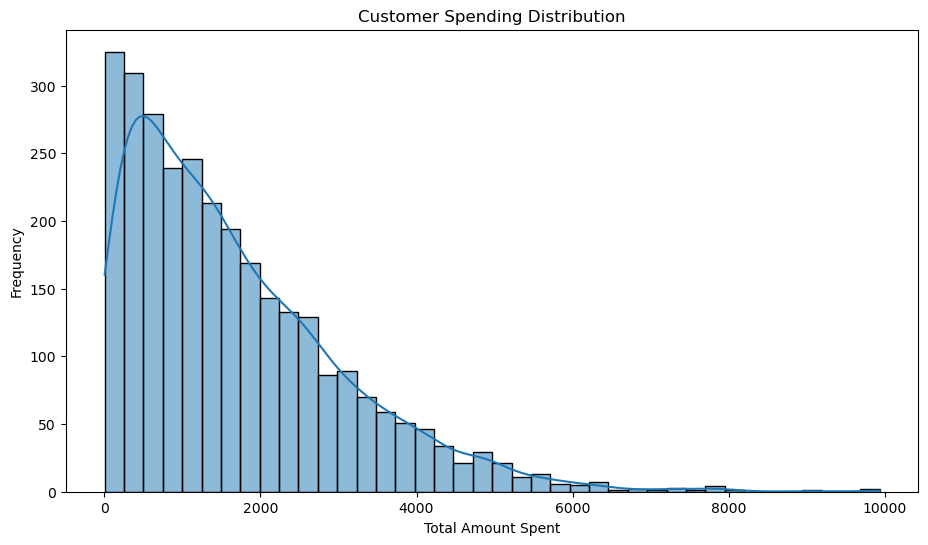

In [31]:
# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['total_amount'], kde=True)
plt.title("Distribution of Total Amount Spent")
plt.xlabel('Total Sales Amount')
plt.ylabel('Frequency')
plt.show()

# Customer Spending Distribution
customer_sales = df.groupby('customer_id')['total_amount'].sum()
plt.figure(figsize=(11,6))
sns.histplot(customer_sales, bins=40, kde=True)
plt.title('Customer Spending Distribution')
plt.xlabel('Total Amount Spent')
plt.ylabel('Frequency')
plt.show()

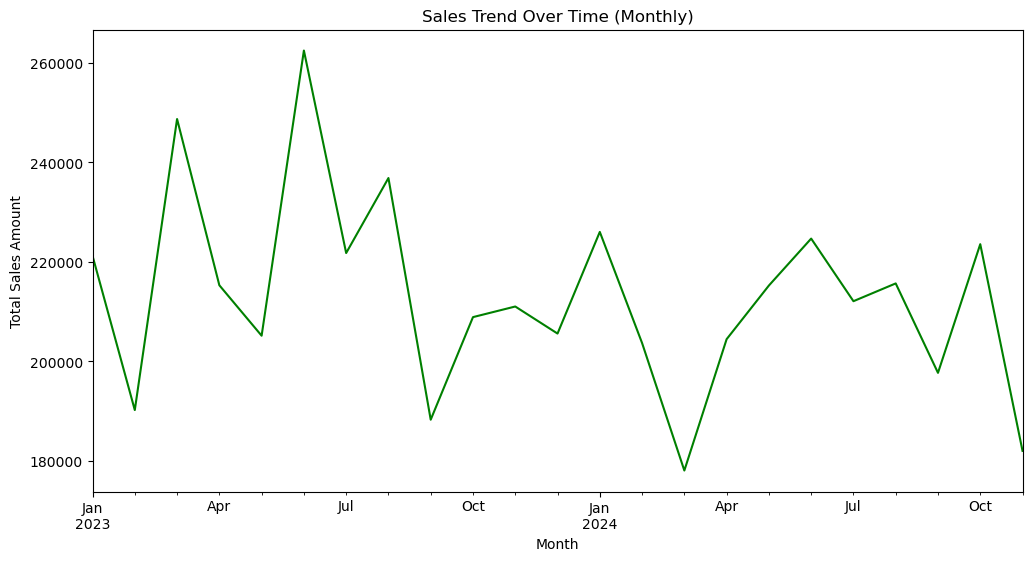

In [33]:
# Sales trend over time
df['month'] = df['timestamp'].dt.to_period('M')
monthly_sales = df.groupby('month')['total_amount'].sum()
plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', color='green')
plt.title('Sales Trend Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.show()




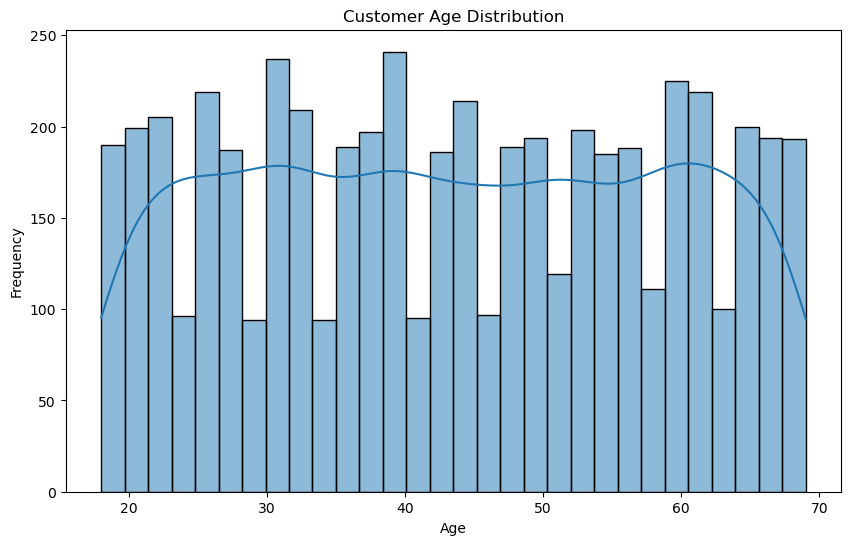

C:\Users\patel\AppData\Local\Temp\ipykernel_13360\3492007446.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='coolwarm')


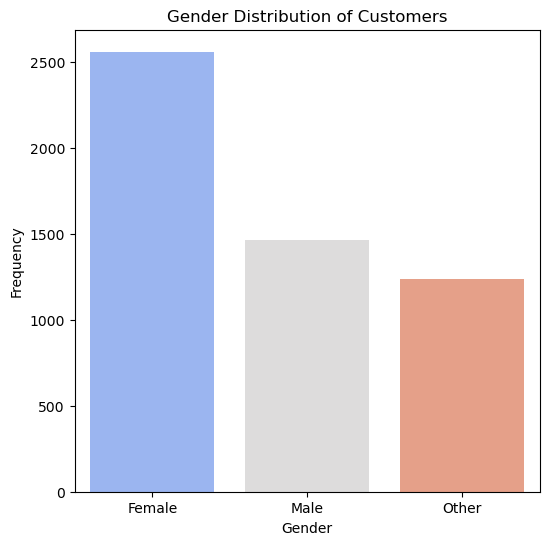

In [35]:
# Age distribution
plt.figure(figsize=(10,6))
sns.histplot(df['customer_age'], bins=30, kde=True)
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Gender distribution
gender_counts = df['customer_gender'].value_counts()
plt.figure(figsize=(6,6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='coolwarm')
plt.title('Gender Distribution of Customers')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

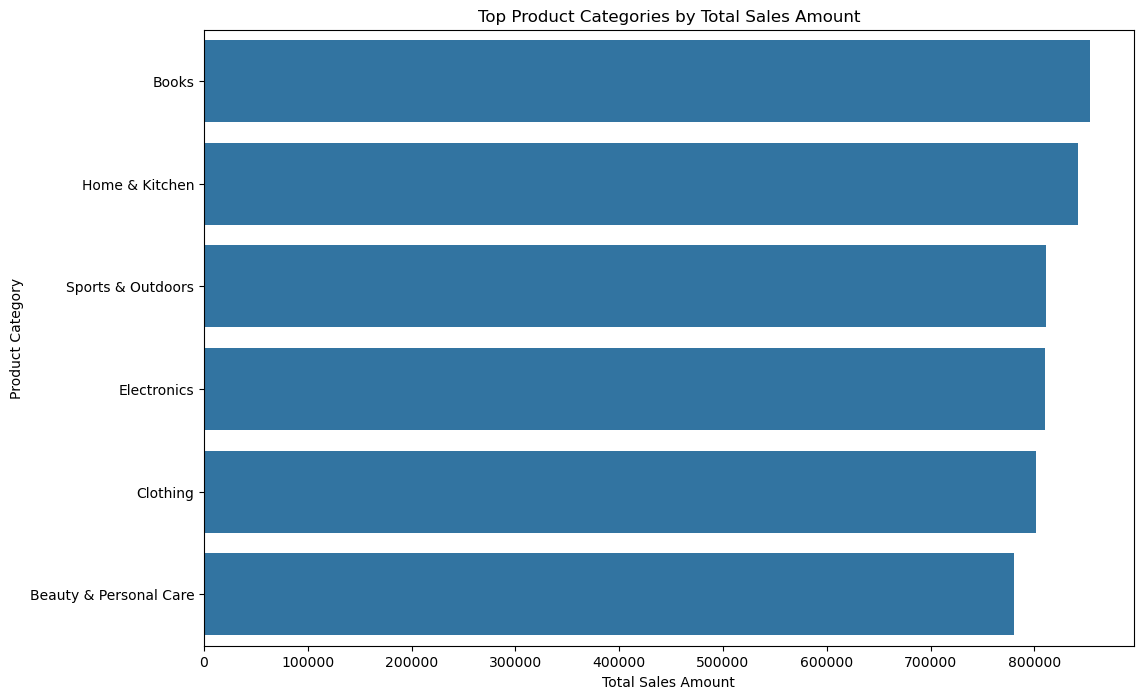

In [37]:
# Grouping by product category and summing total sales
category_sales = df.groupby('product_category')['total_amount'].sum().sort_values(ascending=False).head(10)

# Plotting the top product categories by total sales amount
category_sales = df.groupby('product_category')['total_amount'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='total_amount', y='product_category', data=category_sales.sort_values(by='total_amount', ascending=False).head(10))
plt.title('Top Product Categories by Total Sales Amount')
plt.xlabel('Total Sales Amount')
plt.ylabel('Product Category')
plt.show()

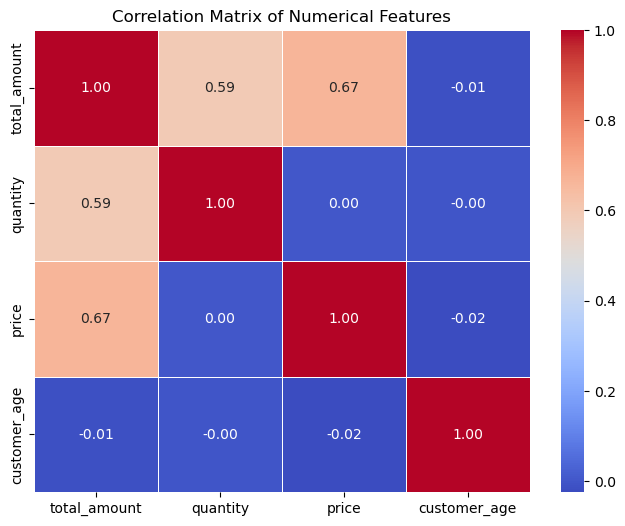

In [39]:
# Selecting numerical columns for correlation analysis
numerical_features = df[['total_amount', 'quantity', 'price', 'customer_age']]  # Adjust as needed

# Calculating the correlation matrix
corr_matrix = numerical_features.corr()

# Plotting the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Silhouette Score: 0.45284661361560674


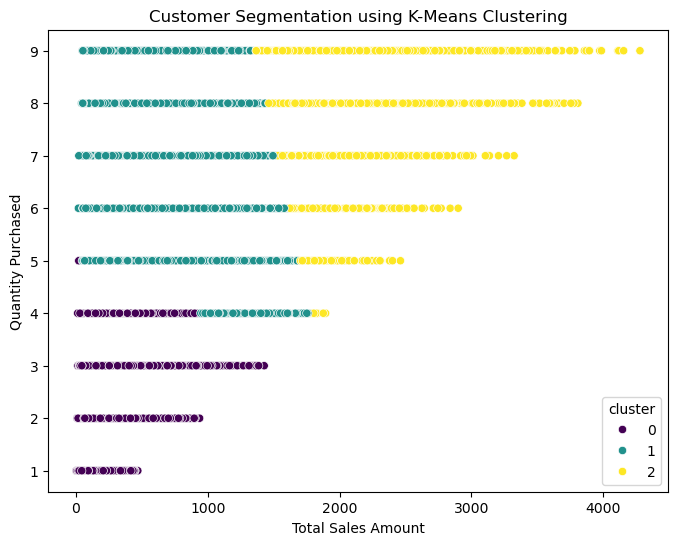

In [41]:
# Prepare data for clustering
features = df[['total_amount', 'quantity']]  # Adjust features as needed
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Calculate silhouette score
sil_score = silhouette_score(scaled_features, df['cluster'])
print(f"Silhouette Score: {sil_score}")

# Visualizing clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['total_amount'], y=df['quantity'], hue=df['cluster'], palette='viridis')
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('Total Sales Amount')
plt.ylabel('Quantity Purchased')
plt.show()


Linear Regression Model - MSE: 124102408.61719628, R²: 0.8139320337727356


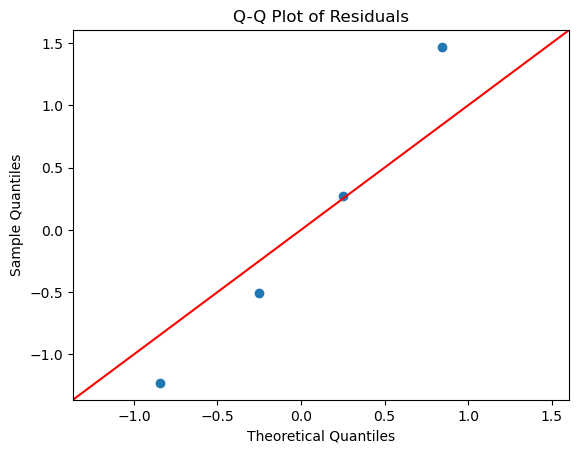

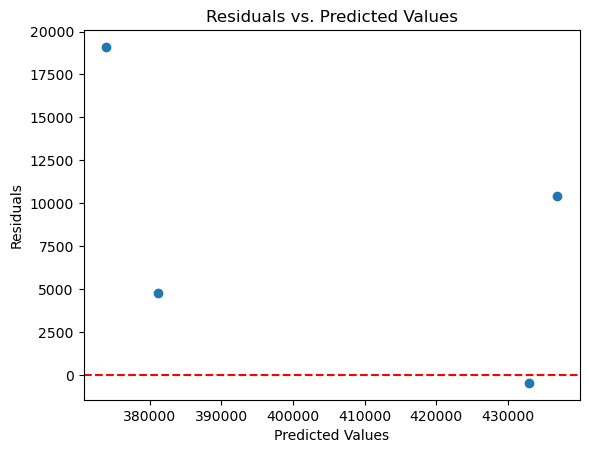

Variance Inflation Factors:
    Feature       VIF
0     month  2.268577
1  quantity  7.404476
2  discount  7.530708


In [43]:
# Train Regression Model
reg_model, mse, r2, y_test, y_pred, X = train_regression_model(df)
print(f"Linear Regression Model - MSE: {mse}, R²: {r2}")

# Regression Assumptions
residuals = y_test - y_pred
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


X_scaled = MinMaxScaler().fit_transform(X)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]
print("Variance Inflation Factors:")
print(vif_data)

Logistic Regression Model Accuracy: 77.463194%
Precision: 77.551020%, Recall: 99.854015%, F1 Score: 87.300574%


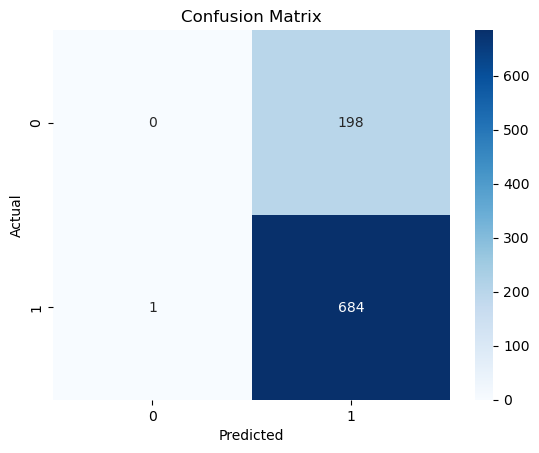

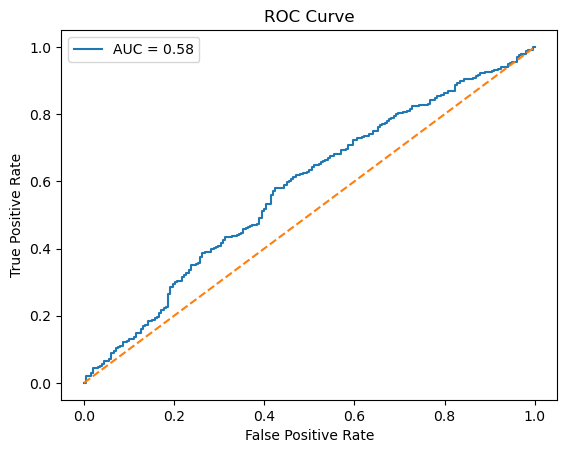

In [45]:
# Train Classification Model
class_model, accuracy, precision, recall, f1, y_test, y_pred, y_proba = train_classification_model(df)
print(f"Logistic Regression Model Accuracy: {accuracy:%}")
print(f"Precision: {precision:%}, Recall: {recall:%}, F1 Score: {f1:%}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Decision Tree Model Accuracy: 68.516421%
Precision: 78.382148%, Recall: 82.043796%, F1 Score: 80.171184%


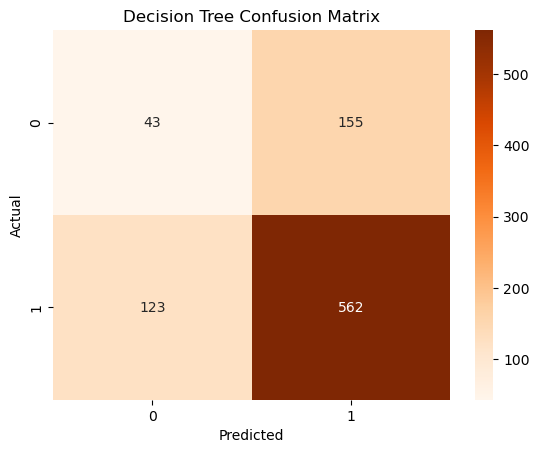

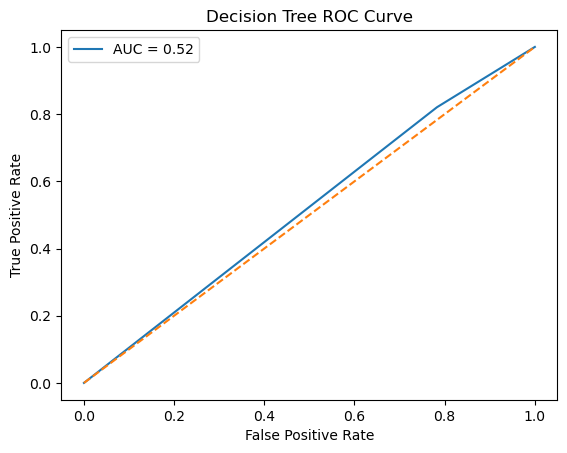

In [47]:
# Train Decision Tree Classifier
dt_model, dt_accuracy, dt_precision, dt_recall, dt_f1, dt_y_test, dt_y_pred, dt_y_proba = train_decision_tree_classifier(df)
print(f"Decision Tree Model Accuracy: {dt_accuracy:%}")
print(f"Precision: {dt_precision:%}, Recall: {dt_recall:%}, F1 Score: {dt_f1:%}")

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(dt_y_test, dt_y_pred)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(dt_y_test, dt_y_proba[:, 1])  # Use probabilities for ROC curve
plt.plot(fpr_dt, tpr_dt, label=f'AUC = {auc(fpr_dt, tpr_dt):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Clustering Model Silhouette Score: 0.5869319571638
Inertia: 945597268.2239324


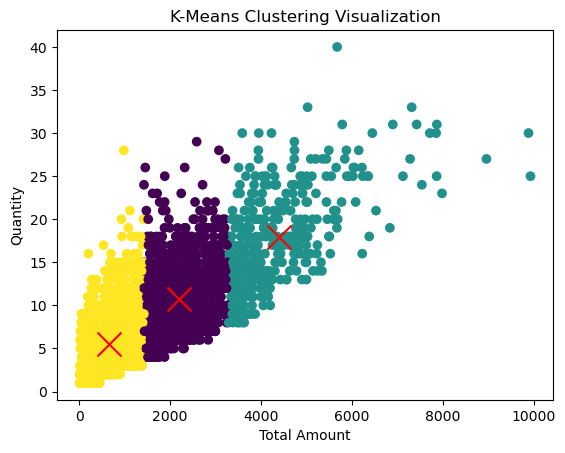

In [49]:
# Train Clustering Model
cluster_model, silhouette, inertia, clustered_data = train_clustering_model(df)
print(f"Clustering Model Silhouette Score: {silhouette}")
print(f"Inertia: {inertia}")


customer_data = df.groupby('customer_id').agg({'total_amount': 'sum', 'quantity': 'sum'})
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Default k=3
clusters = kmeans.fit_predict(customer_data)
customer_data['Cluster'] = clusters

plt.scatter(customer_data['total_amount'], customer_data['quantity'], c=clusters, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.xlabel("Total Amount")
plt.ylabel("Quantity")
plt.title("K-Means Clustering Visualization")
plt.show()

# Save clustered data
customer_data.to_csv("../dataset/customer_segments.csv", index=False)